<a href="https://colab.research.google.com/github/tomradch/MSCIDS_Computational_Language_Technologies/blob/main/5_0_intro_to_rnn_bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beer Review Sentiment Classification

In this Google Colab, we will implement a complete deep learning pipeline for text classification. The task will be to predict the overall sentiment of beer reviews. 

We will introduce multiple models (i.e., CNN, GRU, LSTM) that can be reused in other pipelines or datasets.

Before starting, let's verify that we have a GPU available. If not, please change the runtime type **Runtime -> change runtime type -> hardware accelerator -> GPU**.

In [ ]:
!nvidia-smi

Thu May 11 07:22:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PyTorch

Today, they are "mainly" two big libraries: TensorFlow (Google) and PyTorch (Meta).

We are gonna use the library PyTorch with python. It is a famous framework that is known for its ease of use, simplicity, flexibility, pythonic style, etc. For learn more about it, we recommend the following book "Deep Learning with PyTorch" by  Eli Stevens, Luca Antiga, and Thomas Viehmann.

Finally, one of your new best friend will be the official well-documented PyTorch documentation https://pytorch.org/docs/stable/index.html and its very active forum if you have any question https://discuss.pytorch.org/

If you need an intro to PyTorch, we recommend the following Colab notebooks https://colab.research.google.com/github/theevann/dl4sci-pytorch-webinar/blob/master/offline-notebooks/1-Basics.ipynb.

Source: https://paperswithcode.com/trends


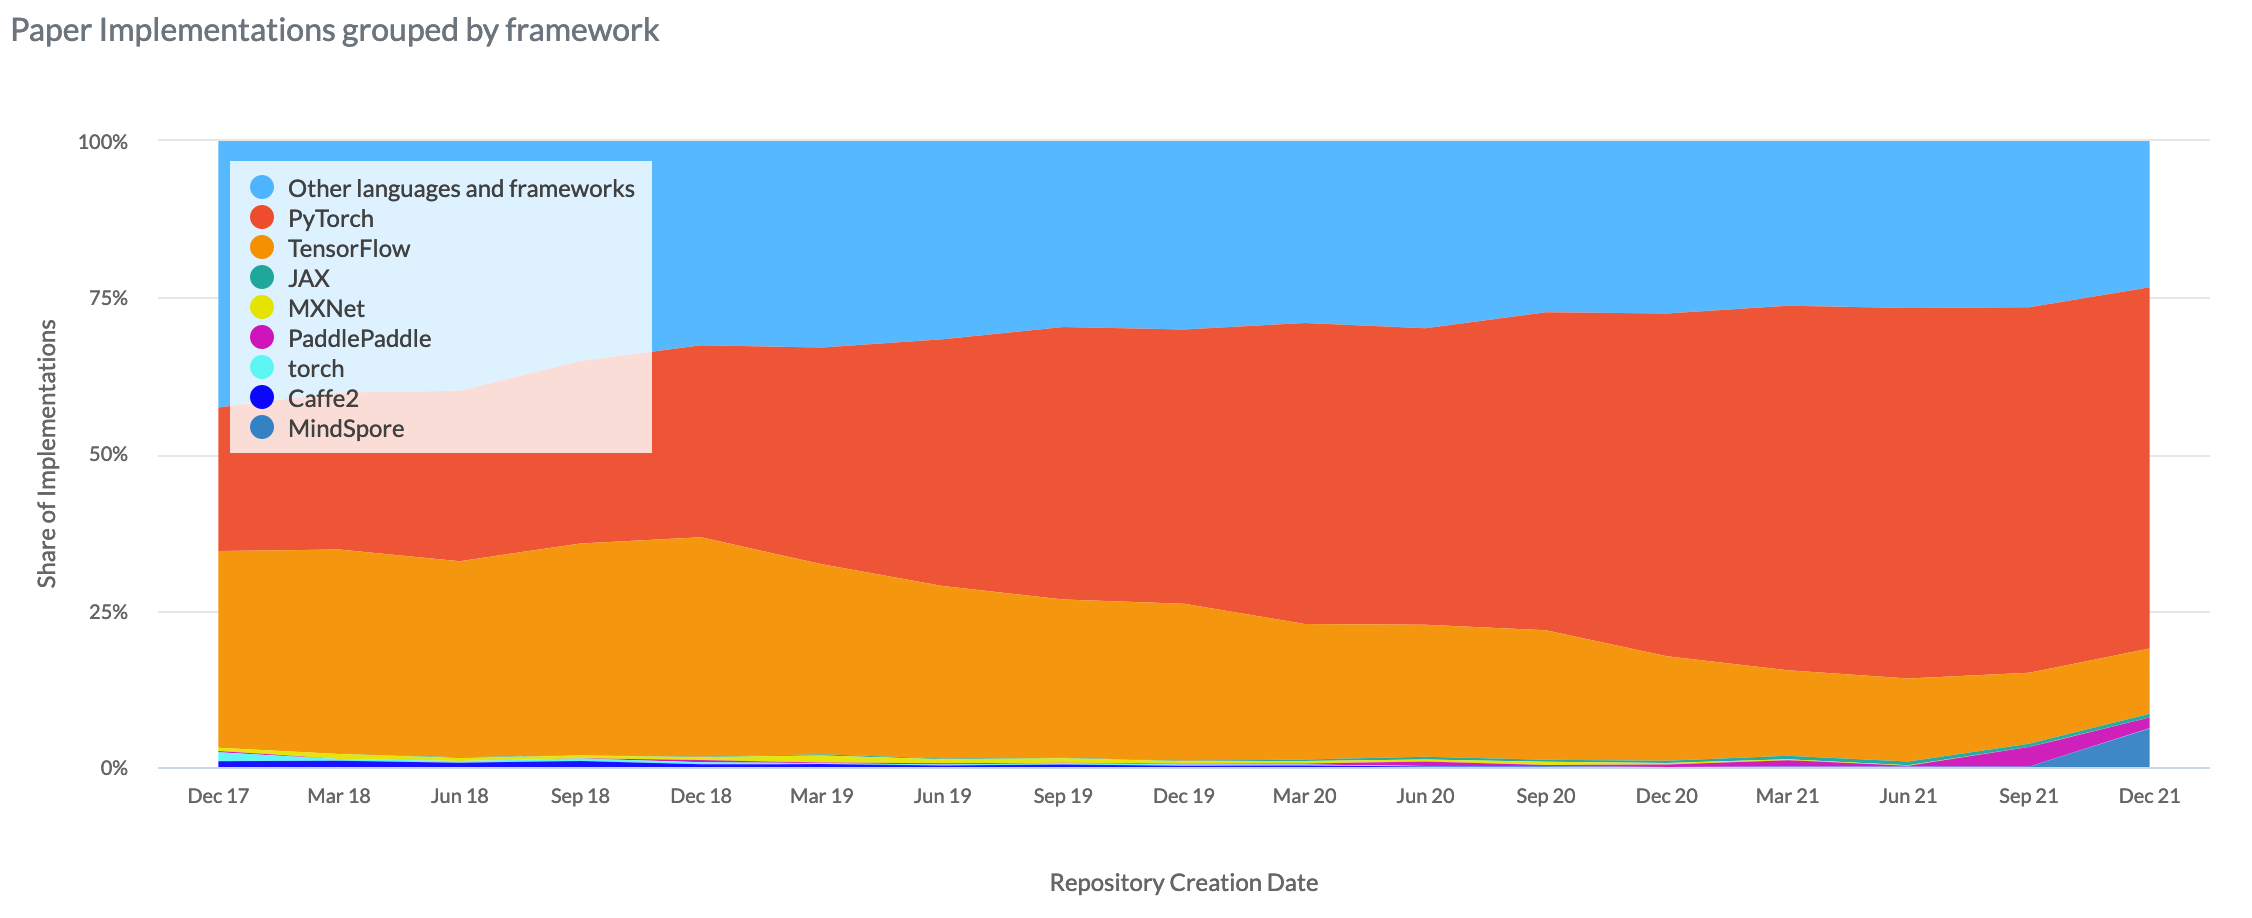

# Deep Learning Pipeline

Assuming our dataset, task, and model are defined, the pipeline is basically always as follows:
1. Create the model
2. Load data and prepare the samples for the model
3. Initialize the optimizer and training hyperparameters

And then the training loop
4. Get a batch of data from the dataset
5. Move data to GPU
6. Do the forward pass to compute the output
7. Compute the loss
8. Compute the gradients with backpropagation (i.e., the forward pass)
9. Update the model parameters 
10. Go to 4) if the model has not converged (or other stopping criterion)


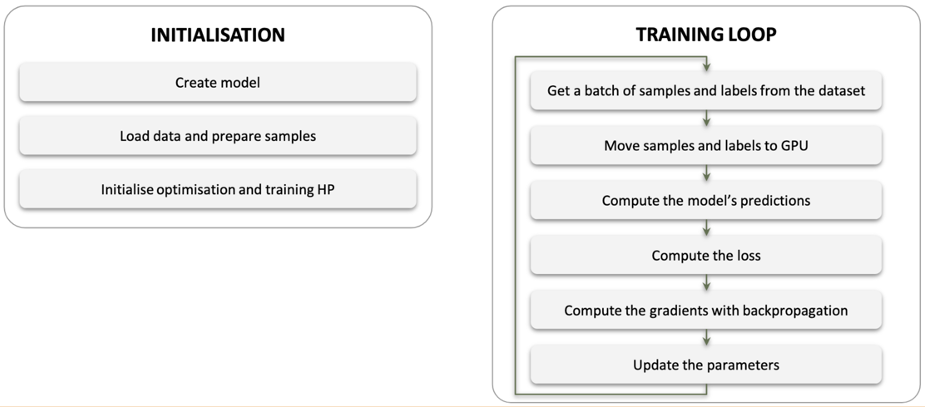

# Import and Parameters

In [ ]:
from os.path import dirname, realpath
import sys
import pickle
import random
import numpy as np
import argparse
import tqdm
import torch
import os
import spacy
import bz2
import pickle
import numpy as np
import time
import os
import tqdm
import torch
import bz2
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import sklearn.metrics
import numpy as np

Generally, we try to write code in a way to be reusable. Therefore, we usually end up with many parameters and hyperparameters:

*   Parameters regarding the **setup** (e.g., do inference, GPUs, logging steps)
*   Parameters regarding the **model** (e.g., hidden dimension, #layers, type of attention)
*   Parameters regarding the **optimization** (e.g., batch size, optimizer, initial learning rate, learning rate scheduler).
*   Parameters regarding the **regularization** (e.g., dropout, weight decay, patience)
*   Parameters regarding the **data** (e.g., what dataset?, filtering parameters, embeddings, fine-tuning embeddings)



In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


def parse_args(print_params=True):
    parser = argparse.ArgumentParser(description='Beer Review Classifier')

    ################
    #     SETUP    #
    ################
    
    #setup
    parser.add_argument('--train', action='store_true', default=True, help='Whether or not to train model')
    parser.add_argument('--dev', action='store_true', default=True, help='Whether or not to use dev set')
    parser.add_argument('--test', action='store_true', default=True, help='Whether or not to run model on test set')
    parser.add_argument('--seed', type=int, default=42, help='Seed')
    parser.add_argument('--logging_steps', type=int, default=1, help='Logging step')
    parser.add_argument('--display_every', type=int, default=20, help='When to display logs')

    # device
    parser.add_argument('--cuda', action='store_true', default=torch.cuda.is_available(), help='enable the gpu')

    # paths
    parser.add_argument('--save_dir', type=str, default='snapshot', help='where to save the snapshot')
    parser.add_argument('--prefix', type=str, default='', help='')
    parser.add_argument('--snapshot', type=str, default=None, help='filename of model snapshot to load[default: None]')



    ################
    #     MODEL    #
    ################

    # model
    parser.add_argument('--model_pred', type=str, default='gru', help="Form of model, i.e, linear, cnn, lstm, gru.")
    parser.add_argument('--num_layers', type=int, default=1, help="Num layers of model_pred to use")
    parser.add_argument('--hidden_dim', type=int, default=128, help="Dim of hidden layer")

    # LSTM specific
    parser.add_argument('--bidirectional', action='store_true', default=True, help='Whether or not to use bidirectionnal (only for LSTM and GRU)')

    # CNN specific
    parser.add_argument('--filter_num', type=int, default=128, help='number of each kind of kernel (only for CNN)')
    parser.add_argument('--filters', type=str, default='3,4,5', help='comma-separated kernel size to use for convolution')



    ################
    # OPTIMIZATION #
    ################

    # learning
    parser.add_argument('--init_lr', type=float, default=1e-3, help='initial learning rate [default: 0.001]')
    parser.add_argument('--epochs', type=int, default=100, help='Max number of epochs for train [default: 100]')
    parser.add_argument('--batch_size', type=int, default=128 if torch.cuda.is_available() else 10, help='batch size for training [default: 128]')
    
    # Regularizers
    parser.add_argument('--dropout', type=float, default=0.0, help='the probability for dropout [default: 0.0]')
    parser.add_argument('--weight_decay', type=float, default=0, help='L2 norm penalty [default: 0]')
    parser.add_argument('--patience', type=int, default=2, help='Num epochs of no dev progress before half learning rate [default: 2]')
    
    parser.add_argument('--tuning_metric', type=str, default='f1', help='Metric to judge dev set results. Possible options loss, accuracy, precision, recall or f1, where precision/recall/f1 are all microaveraged. [default: loss]')



    ################
    #     DATA    #
    ################

    # data
    parser.add_argument('--max_length', default=320, help='Maximum number of tokens')
    parser.add_argument('--embedding', default='beer_data/glove.6B.100d.txt', help='choose what embeddings to use. To use them, please download them to "glove.6B.300d.txt and set this argument to "glove"')

    parser.add_argument('--word_thres', default=2, help='Min frequency to keep a word [default: 2]')
    parser.add_argument('--tune_embedding', action='store_true', default=False, help='Tune embedding during training')

    # data loading
    parser.add_argument('--num_workers', type=int, default=0, help='num workers for data loader')





    args = parser.parse_args("") # Hack for colab
    args.filters = [int(k) for k in args.filters.split(',')]

    if print_params:
        print("\nParameters:")
        for attr, value in sorted(args.__dict__.items()):
            print("\t{}={}".format(attr.upper(), value))

    return args

# Load parameters
args = parse_args()

# Define model name for snapshots
model_name = args.prefix + ('_' if args.prefix is not '' else '') + '{}_{}_{}'.format(args.model_pred, args.dropout, args.weight_decay)
args.file_id = model_name.split('_')[0]
args.model_path = '{}.pt'.format(os.path.join(args.save_dir, model_name))


Parameters:
	BATCH_SIZE=128
	BIDIRECTIONAL=True
	CUDA=True
	DEV=True
	DISPLAY_EVERY=20
	DROPOUT=0.0
	EMBEDDING=beer_data/glove.6B.100d.txt
	EPOCHS=100
	FILTER_NUM=128
	FILTERS=[3, 4, 5]
	HIDDEN_DIM=128
	INIT_LR=0.001
	LOGGING_STEPS=1
	MAX_LENGTH=320
	MODEL_PRED=gru
	NUM_LAYERS=1
	NUM_WORKERS=0
	PATIENCE=2
	PREFIX=
	SAVE_DIR=snapshot
	SEED=42
	SNAPSHOT=None
	TEST=True
	TRAIN=True
	TUNE_EMBEDDING=False
	TUNING_METRIC=f1
	WEIGHT_DECAY=0
	WORD_THRES=2


<>:99: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:99: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-17-68a60e0de306>:99: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  model_name = args.prefix + ('_' if args.prefix is not '' else '') + '{}_{}_{}'.format(args.model_pred, args.dropout, args.weight_decay)


A good practice for reproducibility

In [ ]:
# Set seeds for reproducibility
torch.manual_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)
#torch.use_deterministic_algorithms(True) # This might be needed if you do some operations

# 1) Create Model

As input, the model receives a beer review (i.e., sequence of words/tokens). We will assume that the text is tokenized. Our model will be basically as follows:

1. Convert tokens into word embeddings
2. Use an encoder to compute a fixed-length representation (e.g., LSTM)
3. Have a dense layer (MLP) followed by a projection layer to compute the output distribution (i.e., positive or negative)

Additionnally, we will add some activation functions and dropouts in the model.


In PyTorch, we can create a model by inhereting from `torch.nn.Module`. Basically, `torch.nn` contains all the tools to build your dreamed network!

In a model, you must implement two important functions: `def __init__(self, ...)` and `def forward(self, ...)`. The first function indicates what your model contains (e.g., one LSTM, some dropouts, TanH activation function, another neural module, etc). By setting up components here, the model parameters will be updated **automatically**.

The second function corresponds to the forward pass: how to compute the output?

Once you defined those two functions, PyTorch will handle the rest to compute the gradient and update the model parameters.

In [ ]:
class MyClassifier(nn.Module):
    def __init__(self, embeddings, args):
        super(MyClassifier, self).__init__()

        # A good practice
        self.args = args
        self.device = torch.device("cuda" if args.cuda else "cpu")

        self.dropout = nn.Dropout(args.dropout)

        self.embedding = Embedding(embeddings, args)
        self.text_encoder = TextEncoder(args,
                                        input_size=args.embedding_dim,
                                        hidden_size=args.hidden_dim,
                                        bidirectional=args.bidirectional,
                                        num_layers=1,
                                        keep_all_hiddens=True,
                                        model_form=args.model_pred)

        # We compute what will be the hidden dimension for the final projection (i.e., computing the output distribution)
        if args.model_pred in {'gru', 'lstm'}:
            hidden_dim = args.hidden_dim * (2 if args.bidirectional else 1) * self.args.num_layers
        elif args.model_pred == 'cnn':
            hidden_dim = self.args.filter_num * len(self.args.filters)

        # Using nn.Sequential allows us to align different components
        self.final_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.LeakyReLU(0.2),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, args.num_class, bias=True)
        )
        # The equivalent would be to define 4 variables and call them in the forward pass.

    def forward(self, x_indx, mask_lens, lengths):
        # We adapt the dimensionality of the mask that indicates where are the PAD tokens
        mask_lens = mask_lens.unsqueeze(-1) # B x L x 1

        # Embed the review
        x = self.embedding(x_indx) # B x L x H
        x = self.dropout(x)

        # Encode the review
        all_hidden_vectors = self.text_encoder(x, lengths=lengths) # B x L
        all_hidden_vectors = self.dropout(all_hidden_vectors)

        # Set to 0 hidden vectors with PAD tokens
        all_hidden_vectors = all_hidden_vectors * mask_lens

        # Pooling - how to compute a fixed-length representation
        hidden_vector = self._pool_max(all_hidden_vectors, mask_lens)
        #hidden_vector = torch.mean(all_hidden_vectors, -1) # is another option

        # Apply a non-linear function followed by dropout
        hidden_vector = F.leaky_relu(hidden_vector, 0.2)
        #hidden_vector = F.relu(hidden_vector) # is another option (tanh, elu, selu as well)
        hidden_vector = self.dropout(hidden_vector)

        # Compute outputs
        logits = self.final_proj(hidden_vector)
        probs = F.softmax(logits, dim=-1) # Normalize the log-probabilities into a distributions
        return logits, probs

    def _pool_max(self, hidden_vector, masks_len):
      hidden_vector = hidden_vector + (1. - masks_len) * (-1e9) # We have to be careful that 0 of padded vectors are not the max!
      return torch.max(hidden_vector, dim=1, keepdim=False)[0]

This is an Embedding wraper module. It helps you to initialize the word embedding matrix with a pre-trained one if desired

In [ ]:
class Embedding(nn.Module):
    def __init__(self, embeddings, args):
        super(Embedding, self).__init__()
        self.args = args
        self.device = torch.device("cuda" if args.cuda else "cpu")

        vocab_size, hidden_dim = embeddings.shape
        self.embedding_dim = hidden_dim
        self.vocab_size = vocab_size

        # We create an embedding matrix (that is randomly initialized)
        self.embedding_layer = nn.Embedding(vocab_size, hidden_dim)

        # In case we do have pre-trained embedding matrix, we can copy the weights
        if embeddings is not None:
          self.embedding_layer.weight.data = torch.from_numpy(embeddings)
          self.embedding_layer.weight.requires_grad = args.tune_embedding # If we would like to fine-tune the embeddings or not during training.

    def forward(self, x_indx):
        return self.embedding_layer(x_indx)

This is the text encoder wrapper for multiple neural architecture (e.g., CNN, LSTM, GRU)

In [ ]:
# Different types of encoder
class TextEncoder(nn.Module):
    def __init__(self, args, input_size, hidden_size, bidirectional, num_layers, keep_all_hiddens=False, model_form=None, dropout=None):
        super(TextEncoder, self).__init__()
        self.args = args
        self.device = torch.device("cuda" if args.cuda else "cpu")
        
        self.model_form = model_form if model_form is not None else args.model_form
        self.dropout = nn.Dropout(args.dropout if dropout is None else dropout)

        # This defines if we want to keep all hidden vectors or want to aggregate them directly.
        self.keep_all_hiddens = keep_all_hiddens

        if self.model_form == 'cnn':
            self.cnn = CNN(input_size=input_size, args=args)
        elif self.model_form == 'lstm':
            self.lstm = LSTM(args, input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=num_layers)
        elif self.model_form == 'gru':
            self.gru = GRU(args, input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=num_layers)
        # OPTIONAL Only for curious people
        #elif self.model_form == 'cnn-att':
        #    self.cnn = CNNAtt(input_size=input_size, args=args)
        #elif self.model_form == 'lstm-att':
        #    self.lstm = LSTMAtt(args, input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=num_layers)  
        else:
            raise NotImplementedError("Model form {} not yet supported for encoder!".format(self.model_form))


    def forward(self, x, lengths=None):
        x = self.dropout(x)

        if self.model_form in {'cnn', 'cnn-att'}:
            x = torch.transpose(x, 1, 2) # Switch X to (Batch, Embed, Length) --> CF Doc https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html?highlight=conv1d#torch.nn.Conv1d
            hidden = self.cnn(x, max_pool_over_time=not self.keep_all_hiddens)
        elif self.model_form in {'lstm', 'lstm-att'}:
            hidden = self.lstm(x, lengths, all_hiddens=self.keep_all_hiddens)
        elif self.model_form == 'gru':
            hidden = self.gru(x, lengths, all_hiddens=self.keep_all_hiddens)
        else:
            raise Exception("Model form {} not yet supported for encoder!".format(self.model_form))

        return hidden

And now, let's start with the convolutional neural network!

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, args):
        super(CNN, self).__init__()

        self.args = args

        self.layers = []

        for layer in range(args.num_layers):
            convs = []

            # For each kernel, we will create a convolution layer
            for kernel_size in args.filters:
                # Compute the size of the input vector depending in what layer we are
                in_channels = input_size if layer == 0 else args.filter_num * len(args.filters)

                # Create the convolution layer
                new_conv = nn.Conv1d(in_channels=in_channels, out_channels=args.filter_num, kernel_size=kernel_size)
                
                # THIS step is important. We need to include these model parameters into our class.
                # Usually, if we do something like self.dense = nn.Linear(a, b), it will include automatically the parameters into the class
                # However, as we are creating a model dynamically (because we don't know ahead what is the value of args.num_layers)
                # we must do stip step manually! Also, we need to give a unique name to the component.
                self.add_module('layer_' + str(layer) + '_conv_' + str(kernel_size), new_conv)
                
                convs.append(new_conv)
            
            # We finish creating a layer. We now add it to the model.
            self.layers.append(convs)

    def forward(self, x, max_pool_over_time=True):
        return self._conv(x, max_pool_over_time)
    
    def _conv(self, x, max_pool_over_time):
        layer_activ = x
        for layer in self.layers:
            next_activ = []
            for conv in layer:
                # To have consistent dimension output, we always pad the input
                padded_activ = F.pad(layer_activ, pad=(conv.kernel_size[0] - 1, 0), mode='constant', value=0) #BxDx(L+K-1)

                # We do the convolution followed by an activation function
                result = F.relu(conv(padded_activ))

                # We pool if desired
                if max_pool_over_time:
                    result = self._pool(result) #BxD
                
                # We store the result and move to the next convolution
                next_activ.append(result)

            # concat across channels
            layer_activ = torch.cat(next_activ, 1)

        if not max_pool_over_time:
            layer_activ = layer_activ.transpose(1, 2) #BxLxD
        return layer_activ

    def _pool(self, relu):
        return F.max_pool1d(relu, relu.size(2)).squeeze(-1)

In [ ]:
class LSTM(nn.Module):

    def __init__(self, args, input_size, hidden_size, bidirectional, num_layers):
        super(LSTM, self).__init__()

        self.args = args
        self.layers = []
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=args.dropout if num_layers > 1 else 0,
                            bidirectional=bidirectional)

    def forward(self, x, lengths, all_hiddens=False, return_outputs_and_hidden=False):
        # PyTorch (and other frameworks) are using CuDNN for efficient neural networks.
        # For some reason, for LSTM, GRU, and RNN, the input sequences MUST be sorted by decreasing length
        # Therefore, we will do it manually before feeding the network AND also after in order to have the hidden vectors in the right order

        # 1. We sort the batch (and keep the sorting index) according to their sequencelength in decreasing order
        sorted_lengths, sorted_order = lengths.sort(0, descending=True)
        sorted_input = x[sorted_order] # Here we rearrange the batch
        _, invert_order = sorted_order.sort(0, descending=False) # We store the indeces of the sorting

        # 2. Because all sequences DO NOT have the same length, we might not want to waste GPU resources on useless computation.
        # For example:
        # a) I     am       Diego PAD  PAD
        # b) Ciao  ragazzi  PAD   PAD  PAD
        # c) We    are      doing deep learning
        # 
        # Only c) needs to process the full sequence. In a) and b), only 3 and 2 steps are needed.
        # pack_padded_sequence will exactly help us and not compute 15 "operations" but only 10 in total. Here we save already ~33% of the GPU!
        prepared_input = nn.utils.rnn.pack_padded_sequence(sorted_input, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)

        # If you check the documentation https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        # hidden and cell (useless) will be the final hidden/cell state (NbDirection xBxH) 
        # whereas output contains the values of the hidden states for each time step (NbDirection xBxLxH)
        output, (hidden, cell) = self.lstm(prepared_input)

        result = None
        # Regarding whether we would like to return the final and all hidden vectors
        if not return_outputs_and_hidden:
            if all_hiddens:
                # We unpack the output and reorder all hidden states.
                output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=self.args.max_length)[0] #BxLxH
                result = output.index_select(0, invert_order)
            else:
                # This is the simple case. We just want the final latent representation.
                hidden = hidden.index_select(1, invert_order)
                result = hidden.transpose(0, 1)
                # Unfortunately, we cannot simply do a transpos because the memory representation is scattered.
                # We must rewrite the values in a continuous chunk of memory
                result = result.contiguous().view(x.size(0), -1)
        else:
            # We do the same operation as above.
            output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=self.args.max_length)[0]
            output = output.index_select(0, invert_order)
            hidden = hidden.index_select(1, invert_order)
            hidden = hidden.transpose(0, 1).contiguous().view(x.size(0), -1)
            result = (hidden, output)

        return result

In [ ]:
class GRU(nn.Module):

    def __init__(self, args, input_size, hidden_size, bidirectional, num_layers):
        super(GRU, self).__init__()

        self.args = args
        self.layers = []
        self.gru = nn.GRU(input_size=input_size,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=args.dropout if num_layers > 1 else 0,
                           bidirectional=bidirectional)

    def forward(self, x, lengths, all_hiddens=False):
        # This is nearly the same as LSTM. the ONLY difference is that GRU does not have a "cell" component
        sorted_lengths, sorted_order = lengths.sort(0, descending=True)
        sorted_input = x[sorted_order]
        _, invert_order = sorted_order.sort(0, descending=False)

        prepared_input = nn.utils.rnn.pack_padded_sequence(sorted_input, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)
        output, hidden = self.gru(prepared_input) # Here there is no "cell" alongside the hidden state.

        result = None
        if all_hiddens:
            output = nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=self.args.max_length)[0]
            result = output.index_select(0, invert_order)
        else:
            hidden = hidden.index_select(1, invert_order)
            result = hidden.transpose(0, 1).contiguous().view(x.size(0), -1)

        return result

In [ ]:
# ONLY IF YOU ARE CURIOUS!
# You can have ONE example of an attention mechanism within LSTM or CNN
'''
class LSTMAtt(nn.Module):

    def __init__(self, args, input_size, hidden_size, bidirectional, num_layers, get_att_weights):
        super(LSTMAtt, self).__init__()

        self.args = args
        self.lstm = LSTM(args, input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=num_layers)
        self.dropout = nn.Dropout(args.dropout)
        self.get_att_weights = get_att_weights
        self.attentions = []

    def forward(self, x, lengths, all_hiddens=False):
        hidden, output = self.lstm(x, lengths, return_outputs_and_hidden=True)
        if self.args.num_layers > 1:
            output = output.repeat(1, 1, self.args.num_layers)
        attention_scores = torch.bmm(output, hidden.unsqueeze(2)).squeeze(2)
        soft_attention_weights = F.softmax(attention_scores, 1).unsqueeze(2)
        attention_output = torch.bmm(output.permute(0, 2, 1), soft_attention_weights).squeeze(2)
        concatenated_vector = self.dropout(torch.cat([hidden, attention_output], dim=1))

        if self.get_att_weights:
            self.attentions.append(soft_attention_weights)

        return concatenated_vector


class CNNAtt(nn.Module):

    def __init__(self, input_size, args):
        super(CNNAtt, self).__init__()

        self.args = args
        self.cnn = CNN(input_size, args)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, max_pool_over_time=True):
        hidden = self.cnn(x, max_pool_over_time=True)
        output = self.cnn(x, max_pool_over_time=False)
        attention_scores = torch.bmm(output, hidden.unsqueeze(2)).squeeze(2)
        soft_attention_weights = F.softmax(attention_scores, 1).unsqueeze(2)  # shape = (batch_size, seq_len, 1)
        attention_output = torch.bmm(output.permute(0, 2, 1), soft_attention_weights).squeeze(2)
        concatenated_vector = torch.cat([hidden, attention_output], dim=1)
        return self.dropout(concatenated_vector)
#'''

'\nclass LSTMAtt(nn.Module):\n\n    def __init__(self, args, input_size, hidden_size, bidirectional, num_layers, get_att_weights):\n        super(LSTMAtt, self).__init__()\n\n        self.args = args\n        self.lstm = LSTM(args, input_size=input_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=num_layers)\n        self.dropout = nn.Dropout(args.dropout)\n        self.get_att_weights = get_att_weights\n        self.attentions = []\n\n    def forward(self, x, lengths, all_hiddens=False):\n        hidden, output = self.lstm(x, lengths, return_outputs_and_hidden=True)\n        if self.args.num_layers > 1:\n            output = output.repeat(1, 1, self.args.num_layers)\n        attention_scores = torch.bmm(output, hidden.unsqueeze(2)).squeeze(2)\n        soft_attention_weights = F.softmax(attention_scores, 1).unsqueeze(2)\n        attention_output = torch.bmm(output.permute(0, 2, 1), soft_attention_weights).squeeze(2)\n        concatenated_vector = self.dropout(torc

# 1.1) Create the loss function

As we are doing binary text classification, we will use the standard cross entropy (which is the same as the binary cross entropy with binary labels)

In [ ]:
def compute_losses(y_logits_pred, y_true, args):
    pred_fct = F.cross_entropy
    loss_p = pred_fct(y_logits_pred, y_true, reduction='mean') # Once the loss function is computed for each sample of the batch, we reduce it using the MEAN operation

    return loss_p

# 2.1) Read the data

So far, we have designed our model. That's great!

Now, we need to read the data that we will use and process it. We will use beer reviews from [BeerAdvocate](https://www.beeradvocate.com/). Each beer review also has 5 ratings: appearance, smell, palate, taste, and overall.

Here are two examples. The format is as follow:

**APPERANCE_RATING**   \t  **SMELL_RATING**  \t   **PALATE_RATING**   \t   **TASTE_RATING**   \t  **OVERALL_RATING**   \t   **REVIEW_TEXT**



Sample 1

**0.9 0.9 0.9 0.9 0.9** A chilled 750ml bottle is poured into white wine glasses. A huge pure white foam head fills most of the glass. Below it lies a golden yellow liquid. Plenty of tiny carbonation bubbles are present. Lacing is impressive. A very good saison aroma comes off of Vera Mae. White sugar, musty yeast and grass hops are all detected. I think I can also smell some coriander and orange peel. Some of the grass hop aromas could be due to the dandelions, but I am not sure. Interesting flavors in this beer. Its not nearly as sweet as other saisons I've had. It's fairly dry. Lots of floral flavors, but I'm also getting something akin to banana, but not like you find in a hefeweizen. I'm not tasting any obvious sugars and the hops are subtle. I like how this beer isn't sticky. Coating of my mouth is slight,but a good film is left on my tongue. Carbonation can't be felt as much as I thought it would, considering the number of visible bubbles. This is an excellent, yet hard to obtain saison. Of course, I feel you could probably say that about every style Sean Hill brews. If you can make it to Hill's Farmstead and they have bottles of this available, it would be worth picking up.

Sample 2

**0.4 0.2 0.4 0.2 0.2**	This beer is so memorable that I had to make it my first review. A: hazy amber in color. Poured with less than a finger of head. Good head retention and visible carbonation. S: some aroma of lemon and honey but mostly smells like cough syrup. Bad cough syrup. T: slight taste of lemon and honey, but ginger is predominant. Very medicine like in taste. As someone else posted, this smells and tastes like chloroseptic. M: It is light- to medium-bodied and very smooth on the palate with a moderate amount of carbonation. O: the best thing to say about this is that it is a very unique. This tastes like the worst cough medicine ever invented and does not go down easily. This resulted in a quick drain pour. Normally enjoy the reserve series, but this is one concoction that never should have been created. What's worse is it ruined my taste buds for the rest of the night.

To create a dataset in PyTorch, we need to inherent from `torch.utils.data.Dataset` and implement `def __len__(self)` and `def __get__(self, index)`. The first function indicates how many samples are available while the second returns the sample at the specific index.

During the dataset creation process, we need for each sample:

1. An input (X)
2. A label (y)
3. Optionnally an ID to identify the sample
4. Optionnally whatever information you might find useful (e.g., the full text)

In [ ]:
class FullBeerDataset(torch.utils.data.Dataset):
    MAPPING = { # Mapping of the ratings
        0: 'appearance',
        1: 'smell',
        2: 'palate',
        3: 'taste',
        4: 'overall',
    }

    def __init__(self, args, mode, folder=''):
        self.args = args
        self.name = mode

        self.dataset = []

        # Reversed mapping of the ratings
        self.aspects_to_num = {'appearance':0, 'smell':1, 'palate':2, 'taste':3, 'overall':4}
        
        # Where to read our file (here it will be a tsv)
        path = os.path.join(folder, self.name + '_raw.')

        # Where to save the processed data
        pickle_path = path.replace('_raw', '') + 'pkl'

        # In case we already processed the data, we simply load it
        # Pickle and BZ2 are ways to serialize objects and compress them on disk.
        if os.path.exists(pickle_path):
            print('Loading {}'.format(pickle_path))
            with bz2.BZ2File(pickle_path, 'rb') as fp:
                self.dataset = pickle.load(fp)
        else:
            # We load here spacy that will be used for tokenization
            self.nlp = spacy.load('en_core_web_sm')
            
            txt_path = path + 'tsv'
            print('Loading {}'.format(txt_path))

            # We read the data at once
            with open(txt_path) as file:
                lines = [line.strip() for line in tqdm.tqdm(file, desc='Reading {}'.format(mode))]

          # Then we preprocess each sample and add it to our dataset
            for indx, line in tqdm.tqdm(enumerate(lines), desc='Processing {}'.format(mode)):
                sample = self.processLine(line, indx, self.nlp, self.args, self.aspects_to_num)
                self.dataset.append(sample)

            # Finally, we save the preprocessed data
            with bz2.BZ2File(pickle_path, 'wb') as fp:
                pickle.dump(self.dataset, fp)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,index):
        # Here we decided to represent all our samples into a list. Then accessing the i^th element is trivial.
        # Another alternative could be to use dictionnaries.
        sample = self.dataset[index]
        return sample

    def processLine(self, line, indx, nlp, args, MAPPING):
        # We split ratings and the review
        aspects, text = line.strip().split('\t')
        # Convert the ratings into float
        aspects = [float(x) for x in aspects.split()][:len(MAPPING)]

        labels = aspects
        args.num_aspects = len(labels)
        assert len(labels) == len(MAPPING)

        # Tokenize the review
        text_list = [token.text.lower() for sent in nlp(text).sents for token in sent]

        # Represent a sample as a dictionnary that contains:
        # 1) The full tokenized text
        # 2) the label to predict (i.e., the overall sentiment)
        # 3) the index of the sample (to refer it later)
        sample = {
            'x': None, # to save space, we will infer the word embedding from the text later
            'text': " ".join(text_list),
            'y': labels[MAPPING['overall']],
            'i': indx,
        }

        # For future purposes, we also store all ratings (apperance, smell, palate, taste, and overall)
        for aspect_i, aspect_y in enumerate(labels):
            sample['y_{}'.format(aspect_i)] = torch.FloatTensor([aspect_y])

        return sample

Great! Our dataset is now ready. However, we are missing some data to read ... Let's download some reviews and embeddings.

This archive contains:

1. The train, dev, and test sets in raw/tsv format
2. The train, dev, and test sets already processed (with the extension .pkl)
3. The GloVe word embedding that we will use later

In [ ]:
import locale # This is just a hack; no idea why it does not work without
locale.getpreferredencoding = lambda: "UTF-8"

!rm -rf beer_data.zip *.pkl *.tsv *.txt __MACOSX
!wget https://www.dropbox.com/s/u1ravpvspz54cns/beer_data.zip
!unzip beer_data.zip

--2023-05-11 07:22:50--  https://www.dropbox.com/s/u1ravpvspz54cns/beer_data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/u1ravpvspz54cns/beer_data.zip [following]
--2023-05-11 07:22:51--  https://www.dropbox.com/s/raw/u1ravpvspz54cns/beer_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc93660b323e2ff32c2edbbf1f1b.dl.dropboxusercontent.com/cd/0/inline/B72tMquCPMaC6NL7DRnD_9byuhJrBG7ZE09DrTSCHJ1Dn_q5YEmrsWQTJVfmROltvn7rlnBYSQxuVpVy0kSyx8q8n3n6Ewp_-O8Sbf9IfF5SctBzB6LnkQAwOSXRb4GZX1fpbb5X_iMwVn63a2NLxfwjPhshbs6IMcAkE0xUJNX2EA/file# [following]
--2023-05-11 07:22:51--  https://uc93660b323e2ff32c2edbbf1f1b.dl.dropboxusercontent.com/cd/0/inline/B72tMquCPMaC6NL7DRnD_9byuhJrBG7ZE09DrTSCHJ1Dn_q5YEmrsWQTJVfmROltvn7rlnBYSQ

# 2.2) Read data - tokenization & word embeddings

If you have paid attention in 2.1), **our samples don't have an input "x" defined**. The reason is simple: we need to define our Vocabulary to then represent our input document as a sequence of token/word_ids. Therefore, we want this step to be independent.

The idea is pretty simple. Now we have all our tokenized review texts (from the training data). We know what tokens we need and thus, we can create our word embedding matrix.

To decrease the number of parameters, we will first filter out all words appearing less than 2 times. Moreover, we will use the pre-trained GloVe word embedding to create our word embedding matrix for our words.

In [ ]:
class LanguageIndex(object):
    """
    Creates a word -> index mapping (e.g,. "dad" -> 5)
    and vice-versa.
    """

    def __init__(self, texts, threshold=1):
        """
        Inputs:
            texts -- a list of text (after tokenization)
            threshold -- threshold to filter less frequent words
        """
        self.threshold = threshold

        self.word2idx = {}
        self.idx2word = {}
        self._create_index(texts)

    def _create_index(self, texts):
        # counting for unique words
        word2count = defaultdict(int)
        for text in texts:
            for word in text.split(' '):
                word2count[word] += 1

        # counting unique words
        vocab = sorted({word for word, count in word2count.items() if count >= self.threshold})

        # create word2idx
        self.word2idx["<pad>"] = 0
        self.word2idx["<unknown>"] = 1 # for tokens that we haven't seen in the training set (or not frequent enough)
        for index, word in enumerate(vocab):
            self.word2idx[word] = index + 2

        # create reverse index
        for word, index in self.word2idx.items():
            self.idx2word[index] = word


def get_pretained_glove(word2idx, dataset, fpath):
    def load_glove_embedding():
        word2embedding = {}
        with open(fpath, "r", errors='ignore') as f:
            for (i, line) in tqdm.tqdm(enumerate(f), desc='Reading {}'.format(fpath)):
                data = line.strip().split(" ")
                word = data[0].strip()
                embedding = list(map(float, data[1:]))
                word2embedding[word] = np.array(embedding)
            embedding_dim = len(embedding)

        return word2embedding, embedding_dim

    s = time.time()
    # load glove embedding
    word2embedding, embedding_dim = load_glove_embedding()

    # we randomly initialize our embedding matrix for our vocabulary
    embedding_matrix = np.random.randn(len(word2idx), embedding_dim)

    # replace the embedding matrix by pretrained embedding
    counter = 0
    for word, index in word2idx.items():
        if word in word2embedding:
            embedding_matrix[index, :] = word2embedding[word]
            counter += 1

    # replace the embedding to all zeros for <pad>
    embedding_matrix[word2idx["<pad>"], :] = np.zeros(embedding_dim)
    print("%d out of %d words are covered by the pre-trained embedding." % (counter, len(word2idx)))

    embedding_matrix = embedding_matrix.astype(np.float32)

    print('Loaded embeddings in {:.2f}s'.format(time.time() - s))
    return embedding_matrix


def get_embedding_tensor(texts, args):
    # Create our vocabulary
    vocab = LanguageIndex(texts, args.word_thres)

    # Load our word embeddings
    embeddings = get_pretained_glove(vocab.word2idx, 'beer', args.embedding)
    args.embedding_dim = embeddings.shape[1]

    return vocab, embeddings

# 2.3) Process data

Now, we are ready to read and process our data. Then we can create our vocabulary and word embedding matrix

In [ ]:
train_data, dev_data, test_data = FullBeerDataset(args, 'beer_data/train'), FullBeerDataset(args, 'beer_data/dev'), FullBeerDataset(args, 'beer_data/test')

# Gather all words from training set so that we can create our word embeddings
all_texts = [sample['text'] for sample in train_data]
vocab, embeddings = get_embedding_tensor(all_texts, args)

Loading beer_data/train.pkl
Loading beer_data/dev.pkl
Loading beer_data/test.pkl


Reading beer_data/glove.6B.100d.txt: 400000it [00:11, 36003.40it/s]


26784 out of 33638 words are covered by the pre-trained embedding.
Loaded embeddings in 11.28s


Finally, for each sample we can now represent the review as a sequence of word_ids!

Moreover, we transform the raw ratings (from 0.0 to 1.0) into binary labels. Ratings <= 0.41 will be considered as NEGATIVE and others as POSITIVE sentiment.

In [ ]:
def compute_rating(rat):
    return 0 if float(rat) <= 0.41 else 1

def transform_label(all_data, args):
    unique_labels = set()
    min_, max_ = 1e9, -1e9
    for data in all_data:
        for sample in data:
            for label in sample['y'].tolist():
                if label < min_:
                    min_ = label
                if label > max_:
                    max_ = label
                unique_labels.add(str(label)[:3]) # Convert to str to have a perfect mapping

    # Each rating -> 1 class
    class_dict = {class_label:class_id for class_id, class_label in enumerate(sorted(unique_labels, key=lambda x:float(x)))}
    class_dict = {class_label: (compute_rating(class_label)) for class_label in class_dict.keys()}

    # We store these informations into the arguments
    args.class_dict = class_dict
    args.num_class = len({v for v in class_dict.values()})

    print('Classification problem: ', '{} classes\t'.format(args.num_class), '\t'.join(['{}: {}'.format(i, l) for l, i in class_dict.items()]))

    # Convert rating to classes
    counter = {aspect_i:{k:0 for k in set(class_dict.values())} for aspect_i in range(len(data.aspects_to_num))} # For simple statistics
    for data in all_data:
        for sample in data:
            current_labels = [str(label)[:3] for label in sample['y'].tolist()]
            rating = float(current_labels[-1]) # -1 = overall rating!
            
            new_labels = [class_dict[label] for label in current_labels]
            sample['y'] = torch.LongTensor([new_labels[-1]])
            # In case we need them for future work, we store other labels as well
            #for aspect_i, aspect_y in enumerate(range(len(data.aspects_to_num))):
            #    sample['y_{}'.format(aspect_i)] = torch.LongTensor([sample['y_{}'.format(aspect_i)]])
            #    counter[aspect_i][sample['y_{}'.format(aspect_i)][0].item()] += 1
    #print('Balance of aspects')
    #for aspect_i in range(len(data.aspects_to_num)):
    #    print('{} - Aspect {}'.format(FullBeerDataset.MAPPING[aspect_i].capitalize(), aspect_i))
    #    tot = sum(list(counter[aspect_i].values()))
    #    for k, v in sorted(counter[aspect_i].items(), key=lambda x:int(x[0])):
    #        print('\t{}: {:5.2f} ({:6d})'.format(k, 100.0 * v/tot, v))

In [ ]:
print('Preparing labels')
transform_label([train_data, dev_data, test_data], args)

Preparing labels
Classification problem:  2 classes	 0: 0.2	0: 0.3	0: 0.4	1: 0.6	1: 0.8	1: 1.0


Now, we do have all the desired labels to predict. Now we prepare the input text (i.e., x).

Basically, now that we have tokenized our input documents, we can replace them with word indeces from the word embedding matrix.

Another important step consists in padding the samples. Indeed, a batch of document must have the same (theoretically) length. Therefore, we will pad all sequences to `max_seq_length` and store their true `length`. Finally, we will also generate a binary `mask` that indicates what tokens are used.

In [ ]:
def text2idx(text, max_seq_length, word2idx):
    input_ids = []

    # Split into words
    words = text.strip().split(" ")
    length = len(words)

    # We truncate the input document if it's too long.
    if len(words) > max_seq_length:
        words = words[0:max_seq_length]
        length = max_seq_length

    # Replace the words by their word embedding idx.
    for word in words:
        word = word.strip()
        try:
            input_ids.append(word2idx[word])
        except:
            # if the word is not exist in word2idx, use <unknown> token
            input_ids.append(1) # = <unknown>

    # The mask has 1 for real tokens and 0 for padding tokens.
    input_mask = [1] * len(input_ids)

    # zero-pad up to the max_seq_length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)

    # Finally, we transform those vectors into tensors.
    return torch.LongTensor(input_ids), torch.FloatTensor(input_mask), length

In [ ]:
# Put word indices in the samples and create tensors
for sub_data in [train_data, dev_data, test_data]:
    for sample in tqdm.tqdm(sub_data.dataset, desc='Preprocessing'):
        sample['x'], sample['mask_len'], sample['len'] = text2idx(sample['text'], args.max_length, vocab.word2idx)
        sample['y'] = torch.LongTensor([sample['y']]) # Put the target label into a tensor
        #for aspect_i in range(len(train_data.aspects_to_num)):
        #    sample['y_{}'.format(aspect_i)] = torch.LongTensor([sample['y_{}'.format(aspect_i)]])

Preprocessing: 100%|██████████| 5000/5000 [00:00<00:00, 7921.80it/s]


Finally, we propose to load out data using `torch.utils.data.Dataloader`. The great thing in PyTorch is that we can parallelize this stage. However, it is not always more efficient to use more than one core. It will depend on multiple factors: loading time, preprocessing time if done on the fly, is the data loader the bottleneck, etc.

In [ ]:
def get_train_loader(train_data, args):
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=args.batch_size,
        shuffle=True, # Pay attention that we can shuffle the samples for training
        num_workers=args.num_workers, # And specify how many working we want.
        drop_last=False) # Finally, it is possible to drop the last batch if its size is smaller than args.batch_size. In some applications, it is easier to ignore it instead of handling it.
    return train_loader


def get_dev_or_test_loader(dev_data, args):
    dev_loader = torch.utils.data.DataLoader(
        dev_data,
        batch_size=args.batch_size,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=args.num_workers,
        drop_last=False)
    return dev_loader

# 3) Initialize the model, the optimizer, and the metrics

Good! We have designed a model, we have data and have processed it. Let's finish the preparation by initializing the model and the optimization function.

Below, we initialize the model or load a checkpoint for further fine-tuning or inference.

In [ ]:
def get_model(args, snapshot, embeddings):
    model = None
    if snapshot is None:
        model = MyClassifier(embeddings, args)
    else:
        print('\nLoading model from [%s]...' % snapshot)
        try:
            model = torch.load(snapshot) # By default, torch.load will load the model on the device it has been trained (most often GPU)
        except:
            try:
                # If we don't have a GPU available, we will load the model on CPU
                model = torch.load(snapshot, map_location='cpu')
            except:
                print("Sorry, This snapshot doesn't exist."); exit()

    return model

In [ ]:
print('Creating models')
model = get_model(args, args.snapshot, embeddings)

Creating models


We also prepare our optimization function. I would recommend to always start with `torch.optim.Adam`.


In [ ]:
def get_optimizer(model_, args):
    def compute_params(model, model_name):
        params_require_grad = [param for param in model.parameters() if param.requires_grad]
        print('{:>9} parameters - {}'.format(sum([np.prod(param.shape) for param in params_require_grad], 0), model_name))

    optimizer = torch.optim.Adam
    compute_params(model_, 'Total')
    return optimizer(model_.parameters()) #.parameters() -> returns only parameters that require to be updated with their gradient

Now, we prepare the metric computation to evaluate the performance of our model. We will report standard metrics such as accuracy, precision, etc.

In [ ]:
def get_metrics(preds, golds, num_class, args):
    metrics = {}

    metrics['accuracy'] = sklearn.metrics.accuracy_score(y_true=golds, y_pred=preds)
    metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(y_true=golds, y_pred=preds)
    avg_type = 'binary'
    metrics['precision_{}'.format(avg_type)] = sklearn.metrics.precision_score(y_true=golds, y_pred=preds, average=avg_type)
    metrics['recall_{}'.format(avg_type)] = sklearn.metrics.recall_score(y_true=golds, y_pred=preds, average=avg_type)
    metrics['f1_{}'.format(avg_type)] = sklearn.metrics.f1_score(y_true=golds, y_pred=preds, average=avg_type)

    # Clean the binary
    if num_class == 2:
        for k in list(metrics.keys()):
            if k.endswith('_binary'):
                metrics[k.replace('_binary', '')] = metrics.pop(k)

    return metrics

In [ ]:
# This is only to display information. No need to spend time on it
def collate_epoch_stat(epoch_details, mode, args):
    stat_dict = {}
    log_statement_details = ''
    for metric in sorted(epoch_details):
        loss = epoch_details[metric]
        stat_dict['{}_{}'.format(mode, metric)] = loss

        log_statement_details += '\n'
        if metric.startswith('confusion'):
            max_digits = len(str(np.max(loss)))
            log_statement_details += '{}:\n{}'.format(metric, '\n'.join([''.join(['{number:{width}d}'.format(width=max_digits+1, number=xx) for xx in x]) for x in loss.tolist()]))
        else:
            if isinstance(loss, dict):
                log_statement_details += '\n' + metric + '\n'
                for k, v in loss.items():
                    if k.startswith('confusion'):
                        max_digits = len(str(np.max(v)))
                        log_statement_details += '\t{}:\n{}\n'.format(k, '\n'.join([''.join(['{number:{width}d}'.format(width=max_digits + 1, number=xx) for xx in x]) for x in v.tolist()]))
                    else:
                        log_statement_details += '\t{}:{:8.4f}\n'.format(k, v)
            else:
                log_statement_details += '{}:{:8.4f}'.format(metric, loss)

    log_statement = '{}'.format(log_statement_details)

    return stat_dict, log_statement

# 4) TRAINING LOOP

We are almost there! We are ready to implement our training loop. Let's recap what are the necessary steps.

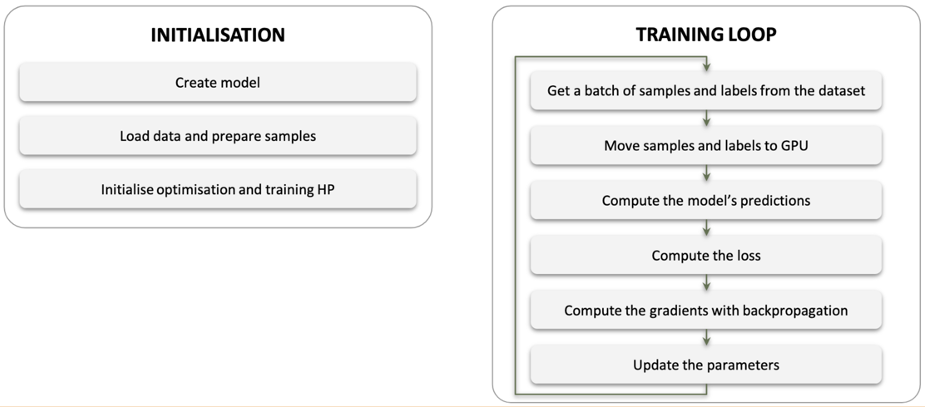


Since the training loop is similar to the inference one, we will implement a `run_epoch` function to do it. Let's start

In [ ]:
def run_epoch(data_loader, train_model, model, optimizer, step, args):
    device = torch.device("cuda" if args.cuda else "cpu")

    # Init metrics and prediction tables
    losses = {'loss': [],}
    preds_y, golds_y, texts = [], [], []

    display_counter = 1
    # We iterate over the dataset
    for batch in tqdm.tqdm(data_loader):
        # Save input and label
        #print(batch.keys())
        texts += batch['text']
        current_gold = batch['y'].squeeze().tolist()
        golds_y += current_gold

        # Transfer to GPU
        x_indx = batch['x'].to(device)
        y_true = batch['y'].squeeze().to(device)
        lengths = batch['len'].to(device)
        mask_lens = batch['mask_len'].to(device)

        # Forward pass
        y_logits, y_probs = model(x_indx, mask_lens=mask_lens, lengths=lengths)
        loss = compute_losses(y_logits, y_true, args)

        # Backward pass + model update
        # ONLY in training mode
        if train_model:
            optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
            loss.backward() # Now that gradients have been empties, we compute the new ones using the loss
            optimizer.step() # We do gradient update with our optimization function.

        # Monitoring
        losses['loss'].append(loss.item())
        if train_model:
            if display_counter % args.display_every == 0:
                display_counter += 1
                print('Loss: {:.4f}'.format(losses['loss'][-1]))

        # We store the prediction
        preds_y += torch.argmax(y_probs, dim=1).tolist()
        
    # Compute and save metrics
    epoch_metrics = {}
    epoch_metrics['y'] = get_metrics(preds_y, golds_y, args.num_class, args)
    epoch_stat = {k:np.mean(v) for k, v in losses.items()}
    for metric_k in epoch_metrics.keys():
        epoch_stat[metric_k] = epoch_metrics[metric_k]

    return epoch_stat, step, losses, preds_y, golds_y, texts

Voilà! We are ready to use this function for training and validation.

For training, we will train and stop using early stopping. Basically, we continue training the model until the validation accuracy stops increasing for more than `args.patience` epochs. Each time we hit a better accuracy, we save the model.

In PyTorch, we indicate to the model that we are in training mode using `mode.train()`. This allows the framework to compute correctly dropout, batchnorm, and prepare the gradient computation phase. During inference or test time, we need to use `mode.eval()` to compute correctly dropout and batchnorm. For efficient purposes, we should also encapsulate the inference loop within `with torch.no_grad()`.

In [ ]:
def train_model(train_data, dev_data, model, embeddings, args):
    device = torch.device("cuda" if args.cuda else "cpu")

    # Move the model to the GPU if not done
    if args.cuda:
        model = model.to(device)

    # Some initialization
    args.lr = args.init_lr
    optimizer = get_optimizer(model, args)
    num_epoch_sans_improvement = 0
    step = 0
    tuning_key = args.tuning_metric
    best_func = max
    train_loader = get_train_loader(train_data, args)
    dev_loader = get_dev_or_test_loader(dev_data, args)
    best_epoch = -1

    all_epochs_stats = []
    for epoch in range(1, args.epochs + 1):
        print("\n\n-------------\n\nEpoch {}:\n".format(epoch))

        print('Train')
        key_prefix = 'train'
        model.train() # Important! We switch the model to training model
        epoch_details, step, _, _, _, _ = run_epoch(
            data_loader=train_loader,
            train_model=True,
            model=model,
            optimizer=optimizer,
            step=step,
            args=args,)

        # Collate all statistics obtained through the epoch.
        epoch_stats_, log_statement = collate_epoch_stat(epoch_details, key_prefix, args)
        #print(log_statement)
        epoch_stats = epoch_stats_

        # Now we compute the validation score to see if we continue training.
        print('Dev')
        key_prefix = 'dev'
        with torch.no_grad():
            model.eval()
            epoch_details, _, _, _, _, _ = run_epoch(
                data_loader=dev_loader,
                train_model=False,
                model=model,
                optimizer=None,
                step=None,
                args=args,)

        epoch_stats_, log_statement = collate_epoch_stat(epoch_details, key_prefix, args)
        #print(log_statement)

        for k, v in epoch_stats_.items():
            assert k not in epoch_stats
            epoch_stats[k] = v

        all_epochs_stats.append(epoch_stats)

        # Save model if better than the previous best dev accuracy
        all_dev_vals = [epoch_stats['dev_y'][tuning_key] for epoch_stats in all_epochs_stats]
        if best_func(all_dev_vals) == all_dev_vals[-1]:
            # If yes, we restart our counter and save the model
            num_epoch_sans_improvement = 0

            if not os.path.isdir(args.save_dir):
                os.makedirs(args.save_dir)

            # Subtract one because epoch is 1-indexed and arr is 0-indexed
            best_epoch = epoch - 1
            args.best_epoch = best_epoch
            torch.save(model, args.model_path)
        else:
            num_epoch_sans_improvement += 1

        print('\n  ---- Best Dev {} is {:.4f} at epoch {}'.format(args.tuning_metric, all_epochs_stats[best_epoch]['dev_y'][tuning_key], best_epoch + 1))

        # If we haven't obtain an improvement since args.patience epoch, we will stop training.
        if num_epoch_sans_improvement >= args.patience or not args.cuda:
            break

    # Restore the best model that obtained the best dev performance
    model = get_model(args, args.model_path, embeddings)

    return all_epochs_stats, model, step

Finally, once we have trained a model, we can write the testing loop very similarly.

In [ ]:
def test_model(test_data, model, args, step, mode='Test'):
    '''
    Run model on test data, and return loss, accuracy.
    '''
    device = torch.device("cuda" if args.cuda else "cpu")

    if args.cuda:
        model = model.to(device)
    test_loader = get_dev_or_test_loader(test_data, args)
    key_prefix = 'inf_' + mode.lower()

    print("-------------\n{}".format(mode))

    with torch.no_grad():
        model.eval()

        epoch_details, _, losses, preds_y, golds_p, texts = run_epoch(
            data_loader=test_loader,
            train_model=False,
            model=model,
            optimizer=None,
            step=None,
            args=args,)

    test_stats, log_statement = collate_epoch_stat(epoch_details, key_prefix, args)
    #print(log_statement)

    test_stats['inference'] = {}
    test_stats['inference']['preds_y'] = preds_y
    test_stats['inference']['texts'] = texts

    return test_stats


# 5) Let's go!

Congratulations! We are done. We can now train and assess our model!!! Let's give a try

In [ ]:
step = 1
if args.train:
    args.epoch_stats, model, step = train_model(train_data, dev_data, model, embeddings, args)
    save_path = os.path.join(args.save_dir, model_name + '_train_dev.pkl')
    print("Save train/dev results to", save_path) # the model is already saved with ES
    args_dict = vars(args)
    with open(save_path, 'wb') as fp:
        pickle.dump(args_dict, fp)
    best_epoch = args.best_epoch

if args.dev or args.test:
    all_stats = []
    if args.dev:
        dev_stats, dev_key = (test_model(dev_data, model, args, step + 1, mode='Dev'), 'dev')
        all_stats.append((dev_stats, dev_key))
    if args.test:
        test_stats, test_key = (test_model(test_data, model, args, step + 2, mode='Test'), 'test')
        all_stats.append((test_stats, test_key))

    for stats, key in all_stats:
        save_path = os.path.join(args.save_dir, model_name + '_{}.pkl'.format(key))
        print("Save {} results to".format(key), save_path)
        args_dict = vars(args)
        args_dict['{}_stats'.format(key)] = stats
        with open(save_path, 'wb') as fp:
            pickle.dump(args_dict, fp)


   242946 parameters - Total


-------------

Epoch 1:

Train


 90%|████████▉ | 350/391 [00:34<00:04, 10.17it/s]


KeyboardInterrupt: ignored

The model has finished training! It has computed the test performance using the model that achieved the best performance on the validation set.

What's next? You could change the model, the optimization, analyze the error to find some insights etc.